<a href="https://colab.research.google.com/github/blueboxai18/E2/blob/master/DNN_Retinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
!pwd
# !unzip E2-master.zip




/content


In [2]:
#cd regular switch "!" will not work
% cd /content/gdrive/My Drive/DNN_Retina/E2-master/

/content/gdrive/My Drive/DNN_Retina/E2-master


In [4]:
#Go to E2-master directory

!pwd # Linux Commands
!ls -lrt # Lists all contents with details



/content/gdrive/My Drive/DNN_Retina/E2-master
total 29
drwx------ 2 root root 4096 Jun  9 17:06 src
drwx------ 2 root root 4096 Jun  9 17:06 mask
drwx------ 2 root root 4096 Jun  9 17:06 lib
drwx------ 2 root root 4096 Jun  9 17:06 images
-rw------- 1 root root 1496 Jun  9 17:06 run_training.py
-rw------- 1 root root 1271 Jun  9 17:06 run_testing.py
-rw------- 1 root root 4357 Jun  9 17:14 prepare_datasets_DRIVE.py
-rw------- 1 root root 1390 Jun  9 17:22 configuration.txt
drwx------ 2 root root 4096 Jun  9 17:41 DRIVE_datasets_training_testing


In [0]:
#%cd ..

!pwd

!ls -lrt

In [3]:
import numpy as np
import configparser

from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, UpSampling2D, Reshape, core, Dropout
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
from keras.utils.vis_utils import plot_model
from keras.optimizers import SGD

Using TensorFlow backend.


In [4]:
from google.colab import files
src = list(files.upload().values())[0]
open('help_functions.py','wb').write(src)
import help_functions 



Saving help_functions.py to help_functions (1).py


In [0]:
from help_functions import *

In [6]:
from google.colab import files
src = list(files.upload().values())[0]
open('pre_processing.py','wb').write(src)

Saving pre_processing.py to pre_processing (1).py


2698

In [7]:
from google.colab import files
src = list(files.upload().values())[0]
open('extract_patches.py','wb').write(src)
import extract_patches



Saving extract_patches.py to extract_patches (1).py


In [0]:
from extract_patches import get_data_training 

In [0]:
#Define the neural network
def get_unet(n_ch,patch_height,patch_width):
    inputs = Input(shape=(n_ch,patch_height,patch_width))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same',data_format='channels_first')(inputs)
    conv1 = Dropout(0.2)(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same',data_format='channels_first')(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    #
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_first')(pool1)
    conv2 = Dropout(0.2)(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_first')(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    #
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same',data_format='channels_first')(pool2)
    conv3 = Dropout(0.2)(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same',data_format='channels_first')(conv3)

    up1 = UpSampling2D(size=(2, 2))(conv3)
    up1 = concatenate([conv2,up1],axis=1)
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_first')(up1)
    conv4 = Dropout(0.2)(conv4)
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_first')(conv4)
    #
    up2 = UpSampling2D(size=(2, 2))(conv4)
    up2 = concatenate([conv1,up2], axis=1)
    conv5 = Conv2D(32, (3, 3), activation='relu', padding='same',data_format='channels_first')(up2)
    conv5 = Dropout(0.2)(conv5)
    conv5 = Conv2D(32, (3, 3), activation='relu', padding='same',data_format='channels_first')(conv5)
    #
    conv6 = Conv2D(2, (1, 1), activation='relu',padding='same',data_format='channels_first')(conv5)
    conv6 = core.Reshape((2,patch_height*patch_width))(conv6)
    conv6 = core.Permute((2,1))(conv6)
    ############
    conv7 = core.Activation('softmax')(conv6)

    model = Model(input=inputs, output=conv7)

    # sgd = SGD(lr=0.01, decay=1e-6, momentum=0.3, nesterov=False)
    model.compile(optimizer='sgd', loss='categorical_crossentropy',metrics=['accuracy'])

    return model

In [0]:
#Define the neural network gnet
#you need change function call "get_unet" to "get_gnet" in line 166 before use this network
def get_gnet(n_ch,patch_height,patch_width):
    inputs = Input((n_ch, patch_height, patch_width))
    conv1 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(inputs)
    conv1 = Dropout(0.2)(conv1)
    conv1 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(conv1)
    up1 = UpSampling2D(size=(2, 2))(conv1)
    #
    conv2 = Convolution2D(16, 3, 3, activation='relu', border_mode='same')(up1)
    conv2 = Dropout(0.2)(conv2)
    conv2 = Convolution2D(16, 3, 3, activation='relu', border_mode='same')(conv2)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv2)
    #
    conv3 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(pool1)
    conv3 = Dropout(0.2)(conv3)
    conv3 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(conv3)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv3)
    #
    conv4 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(pool2)
    conv4 = Dropout(0.2)(conv4)
    conv4 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv4)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv4)
    #
    conv5 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(pool3)
    conv5 = Dropout(0.2)(conv5)
    conv5 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(conv5)
    #
    up2 = merge([UpSampling2D(size=(2, 2))(conv5), conv4], mode='concat', concat_axis=1)
    conv6 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(up2)
    conv6 = Dropout(0.2)(conv6)
    conv6 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv6)
    #
    up3 = merge([UpSampling2D(size=(2, 2))(conv6), conv3], mode='concat', concat_axis=1)
    conv7 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(up3)
    conv7 = Dropout(0.2)(conv7)
    conv7 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(conv7)
    #
    up4 = merge([UpSampling2D(size=(2, 2))(conv7), conv2], mode='concat', concat_axis=1)
    conv8 = Convolution2D(16, 3, 3, activation='relu', border_mode='same')(up4)
    conv8 = Dropout(0.2)(conv8)
    conv8 = Convolution2D(16, 3, 3, activation='relu', border_mode='same')(conv8)
    #
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv8)
    conv9 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(pool4)
    conv9 = Dropout(0.2)(conv9)
    conv9 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(conv9)
    #
    conv10 = Convolution2D(2, 1, 1, activation='relu', border_mode='same')(conv9)
    conv10 = core.Reshape((2,patch_height*patch_width))(conv10)
    conv10 = core.Permute((2,1))(conv10)
    ############
    conv10 = core.Activation('softmax')(conv10)

    model = Model(input=inputs, output=conv10)

    # sgd = SGD(lr=0.01, decay=1e-6, momentum=0.3, nesterov=False)
    model.compile(optimizer='sgd', loss='categorical_crossentropy',metrics=['accuracy'])

    return model

In [0]:

#!pip install ConfigParser
import configparser

In [0]:
!python3 pre_processing.py

In [0]:
#========= Load settings from Config file
# /content/gdrive/My Drive/DNN_Retina/E2-master/configuration.txt
config = configparser.RawConfigParser()
config.read('configuration.txt')
#patch to the datasets
path_data = config.get('data paths', 'path_local')
#Experiment name
name_experiment = config.get('experiment name', 'name')
#training settings
N_epochs = int(config.get('training settings', 'N_epochs'))
batch_size = int(config.get('training settings', 'batch_size'))



In [12]:
print(path_data)

/content/gdrive/My Drive/DNN_Retina/E2-master/DRIVE_datasets_training_testing/


In [13]:
!python3 prepare_datasets_DRIVE.py

/content/gdrive/My Drive/DNN_Retina/E2-master/DRIVE_datasets_training_testing/
original image: 21_training.tif
ground truth name: 21_manual1.gif
border masks name: 21_training_mask.gif
original image: 27_training.tif
ground truth name: 27_manual1.gif
border masks name: 27_training_mask.gif
original image: 23_training.tif
ground truth name: 23_manual1.gif
border masks name: 23_training_mask.gif
original image: 22_training.tif
ground truth name: 22_manual1.gif
border masks name: 22_training_mask.gif
original image: 24_training.tif
ground truth name: 24_manual1.gif
border masks name: 24_training_mask.gif
original image: 26_training.tif
ground truth name: 26_manual1.gif
border masks name: 26_training_mask.gif
original image: 25_training.tif
ground truth name: 25_manual1.gif
border masks name: 25_training_mask.gif
original image: 28_training.tif
ground truth name: 28_manual1.gif
border masks name: 28_training_mask.gif
original image: 29_training.tif
ground truth name: 29_manual1.gif
border 

In [14]:
#============ Load the data and divided in patches
patches_imgs_train, patches_masks_train = get_data_training(
    DRIVE_train_imgs_original = path_data + config.get('data paths', 'train_imgs_original'),
    DRIVE_train_groudTruth = path_data + config.get('data paths', 'train_groundTruth'),  #masks
    patch_height = int(config.get('data attributes', 'patch_height')),
    patch_width = int(config.get('data attributes', 'patch_width')),
    N_subimgs = int(config.get('training settings', 'N_subimgs')),
    inside_FOV = config.getboolean('training settings', 'inside_FOV') #select the patches only inside the FOV  (default == True)
)


train images/masks shape:
(20, 1, 565, 565)
train images range (min-max): 0.0 - 1.0
train masks are within 0-1

patches per full image: 9500

train PATCHES images/masks shape:
(190000, 1, 48, 48)
train PATCHES images range (min-max): 0.0 - 1.0


In [0]:
!mkdir passion

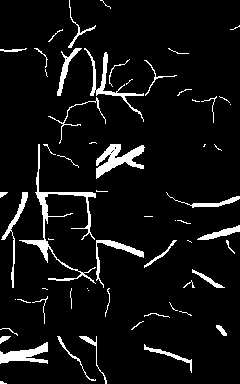

In [17]:
#========= Save a sample of what you're feeding to the neural network ==========
N_sample = min(patches_imgs_train.shape[0],40)
visualize(group_images(patches_imgs_train[0:N_sample,:,:,:],5),'./'+name_experiment+'/'+"sample_input_imgs")#.show()
visualize(group_images(patches_masks_train[0:N_sample,:,:,:],5),'./'+name_experiment+'/'+"sample_input_masks")#.show()

In [18]:
#=========== Construct and save the model arcitecture =====
n_ch = patches_imgs_train.shape[1]
patch_height = patches_imgs_train.shape[2]
patch_width = patches_imgs_train.shape[3]
model = get_unet(n_ch, patch_height, patch_width)  #the U-net model
print ("Check: final output of the network:")
print (model.output_shape)
plot_model(model, to_file='./'+name_experiment+'/'+name_experiment + '_model.png')   #check how the model looks like
json_string = model.to_json()
open('./'+name_experiment+'/'+name_experiment +'_architecture.json', 'w').write(json_string)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ac...)`


Check: final output of the network:
(None, 2304, 2)


10465

In [0]:
#============  Training ==================================
checkpointer = ModelCheckpoint(filepath='./'+name_experiment+'/'+name_experiment +'_best_weights.h5', verbose=1, monitor='val_loss', mode='auto', save_best_only=True) #save at each epoch if the validation decreased

patches_masks_train = masks_Unet(patches_masks_train)  #reduce memory consumption
model.fit(patches_imgs_train, patches_masks_train, nb_epoch=N_epochs, batch_size=batch_size, verbose=2, shuffle=True, validation_split=0.1, callbacks=[checkpointer])



In [0]:
#========== Save and test the last model ===================
model.save_weights('./'+name_experiment+'/'+name_experiment +'_last_weights.h5', overwrite=True)
# test the model
score = model.evaluate(patches_imgs_test, masks_Unet(patches_masks_test), verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])